In [3]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime

## Group Assignment
### Team Number: 17
### Team Member Names: Jack, Jennifer, Justus, Precious
### Team Strategy Chosen: Market Meet (Market Beat or Market Meet)

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.


## Introduction
When finding an objective weighting system for our sorting and selection to operate with, we found it beneficial to draw upon more than just the returns of the stock but instead a combination of the returns, the stock’s market capitalization, its volatility, and the tracking error found from comparing the individual stock to the market. Although it may seem intuitive to just select the stocks that provide the closest average return to the market for our portfolio, the inclusion of the other three metrics in our rating index helps us to assess more than just the returns of each stock, but their overall place in the market.

In [5]:
## Read in portfolio of tickers and create a dataframe
start_date_required = '2023-10-01'
end_date_required = '2024-09-30'
count_days = 0
monthly_vol = []

# This function counts the monthly volume of the stock and finds the average monthly volume
def count_volume(ticker):
    ticker_hist = ticker.history(start=start_date_required, end=end_date_required)
    ticker_hist.index = ticker_hist.index.strftime('%Y-%m-%d')
    # Oct 2023
    filtered_df = ticker_hist.loc[(ticker_hist.index >= '2023-10-01')
                         & (ticker_hist.index < '2023-11-01')]
    if len(filtered_df) >= 18:
        monthly_vol.append(np.mean(filtered_df['Volume']))
        
        # Nov 2023
        filtered_df = ticker_hist.loc[(ticker_hist.index >= '2023-11-01')
                             & (ticker_hist.index < '2023-12-01')]
    if len(filtered_df) >= 18:
        monthly_vol.append(np.mean(filtered_df['Volume']))
        # Dec 2023
        filtered_df = ticker_hist.loc[(ticker_hist.index >= '2023-12-01')
                         & (ticker_hist.index < '2024-01-01')]
    if len(filtered_df) >= 18:
        monthly_vol.append(np.mean(filtered_df['Volume']))
        # jan 2024
        filtered_df = ticker_hist.loc[(ticker_hist.index >= '2024-01-01')
                             & (ticker_hist.index < '2024-02-01')]
    if len(filtered_df) >= 18:
        monthly_vol.append(np.mean(filtered_df['Volume']))
        # Feb 2024
        filtered_df = ticker_hist.loc[(ticker_hist.index >= '2024-02-01')
                             & (ticker_hist.index < '2024-03-01')]
    if len(filtered_df) >= 18:
        monthly_vol.append(np.mean(filtered_df['Volume']))
        # March 2024
        filtered_df = ticker_hist.loc[(ticker_hist.index >= '2024-03-01')
                             & (ticker_hist.index < '2024-04-01')]
    if len(filtered_df) >= 18:
        monthly_vol.append(np.mean(filtered_df['Volume']))
        # April 2024
        filtered_df = ticker_hist.loc[(ticker_hist.index >= '2024-04-01')
                             & (ticker_hist.index < '2024-05-01')]
    if len(filtered_df) >= 18:
        monthly_vol.append(np.mean(filtered_df['Volume']))
        # May 2024
        filtered_df = ticker_hist.loc[(ticker_hist.index >= '2024-05-01')
                             & (ticker_hist.index < '2024-06-01')]
    if len(filtered_df) >= 18:
        monthly_vol.append(np.mean(filtered_df['Volume']))
    
        # June 2024
        filtered_df = ticker_hist.loc[(ticker_hist.index >= '2024-06-01')
                             & (ticker_hist.index < '2024-07-01')]
    if len(filtered_df) >= 18:
        monthly_vol.append(np.mean(filtered_df['Volume']))
        # July 2024
        filtered_df = ticker_hist.loc[(ticker_hist.index >= '2024-07-01')
                             & (ticker_hist.index < '2024-08-01')]
    if len(filtered_df) >= 18:
        monthly_vol.append(np.mean(filtered_df['Volume']))
        # Aug 2024
        filtered_df = ticker_hist.loc[(ticker_hist.index >= '2024-08-01')
                             & (ticker_hist.index < '2024-09-01')]
    if len(filtered_df) >= 18:
        monthly_vol.append(np.mean(filtered_df['Volume']))
         
        # Sept 2024
        filtered_df = ticker_hist.loc[(ticker_hist.index >= '2024-09-01')
                             & (ticker_hist.index < '2024-10-01')]
    if len(filtered_df) >= 18:
        monthly_vol.append(np.mean(filtered_df['Volume']))

    return np.mean(monthly_vol)


In [12]:
## function that takes in a dataframe of stock tickers removes unlisted, low volume or stocks not denominated in USD or CAD
def remove_unwanted(df):
    drop_rows = []
    for i in range(len(df) - 1):
        try:
            ticker = yf.Ticker(df.iloc[i,0])
            currency = ticker.info.get('currency')
            if currency not in ['USD', 'CAD']:
                drop_rows.append(i)
                continue
            if (count_volume(ticker) < 100000):
                drop_rows.append(i)
                continue
        except: 
            drop_rows.append(i)
            continue
    df.drop(drop_rows, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


In [13]:
# Retrieving tickers from csv file
tickers = pd.read_csv('Tickers_Example.csv', header=None)
tickers = tickers.rename(columns={0: 'Tickers'})

df = remove_unwanted(tickers)
df.head()

,Tickers
0,AAPL
1,ABBV
2,ABT
3,ACN
4,AIG


## Choosing our Time Frame For S&P500 and TSX60
We decided to create our portfolio with a three year time period, from 2021-01-01 to 2024-11-02. Choosing a three year period allows us to mitigate short term market volatility that could distort the relationship between the portfolio and the S&P500 and TSX60 indices. For instance, a shorter time period such as one year may include anomalies from recent trends in the market that do not accurately reflect the portfolio long term. This is especially important when calculating volatility as it can be inflated by short-term price swings. Furthermore, a three year time period is long enough to capture different market cycles to provide a more accurate representation of how the portfolio will perform under different market conditions. This ensures the portfolio is not biased towards a single market trend, allowing us to better evaluate its consistency. 

In [16]:
# Retrieving data from S&P500 
start_date = '2021-01-01'
end_date = '2024-11-02'

sp500_ticker = yf.Ticker('^GSPC')
sp500 = sp500_ticker.history(start=start_date, end=end_date, interval='1mo')[['Close']]
sp500.index = sp500.index.strftime('%Y-%m-%d')
sp500_returns = sp500.ffill().pct_change().dropna()
sp500_returns.rename(columns={'Close': 'S&P500 Returns'}, inplace=True)

In [18]:
# Getting tsx historical data
tsx_ticker = yf.Ticker('XIU.TO')
tsx = tsx_ticker.history(start=start_date,end=end_date, interval='1mo')[['Close']]
tsx.index = tsx.index.strftime('%Y-%m-%d')
#tsx.head()
tsx_returns = tsx.ffill().pct_change().dropna()
tsx_returns.rename(columns={'Close': 'TSX60 Returns'}, inplace=True)

In [20]:
# combining dataframe to get total pct change 
sp500tsx60 = sp500_returns.join(tsx_returns)
sp500tsx60['Total % Change'] = sp500tsx60.mean(axis=1)
sp500tsx60.head()

,S&P500 Returns,TSX60 Returns,Total % Change
Date,,,
2021-02-01,0.026091,0.036510,0.031301
2021-03-01,0.042439,0.052981,0.047710
2021-04-01,0.052425,0.023050,0.037737
2021-05-01,0.005486,0.030849,0.018168
2021-06-01,0.022214,0.033423,0.027818


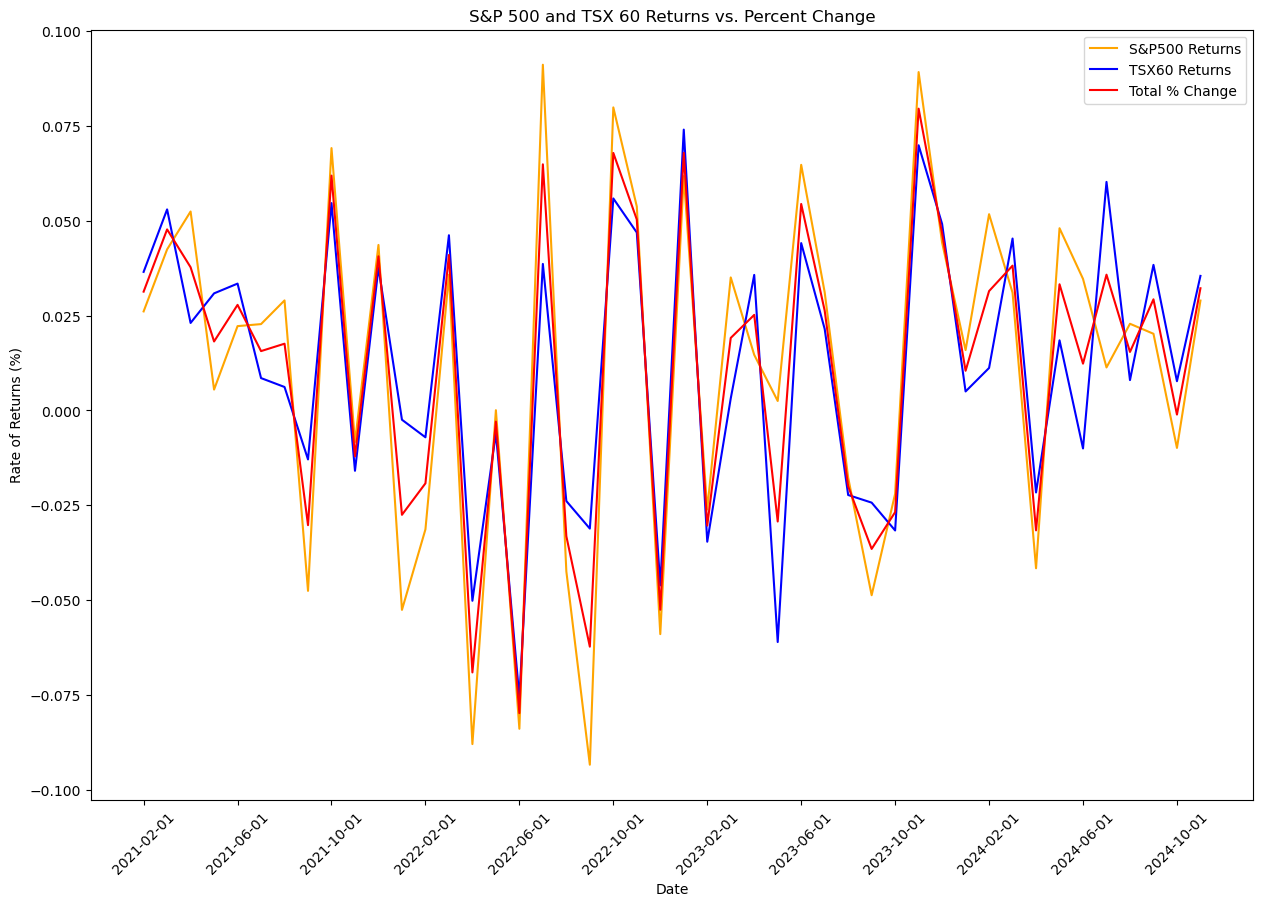

In [22]:
# Plotting the S&P 500 and TSX 60 Returns alongside the percent change
plt.figure(figsize=(15,10))

plt.plot(sp500tsx60["S&P500 Returns"], color = 'orange',  label="S&P500 Returns")
plt.plot(sp500tsx60["TSX60 Returns"], color = 'blue',  label="TSX60 Returns")
plt.plot(sp500tsx60["Total % Change"], color = 'red',  label="Total % Change")
plt.xticks( ["2021-02-01", "2021-06-01", "2021-10-01", "2022-02-01", "2022-06-01", "2022-10-01", 
             "2023-02-01", "2023-06-01", "2023-10-01", "2024-02-01", "2024-06-01", "2024-10-01"], rotation = 45)

plt.title('S&P 500 and TSX 60 Returns vs. Percent Change')
plt.ylabel('Rate of Returns (%)')
plt.xlabel('Date')
plt.legend(loc='best')

The graph above analyzes the Rate of Return for the S&P 500 and the TSX and thier total percent change. Using these metrics we can see the general trend that is being followed by both indexes, with either rising and falling by about the same amount as the other, made even more clear by the overlapping lines. Considering historical rates of return can tell us about how profitable an investment was in the past and can lead use to infer about the future. In our cause, looking at this data gives us a pathway that we would like our own ideal portfolio to follow. If our portfolio can also match the pace of the trend lines above, and hence match around the same rate of return historically, then it is more likely to meet the market index as it's rate or returns will also follow the S&P and TSX 60 as closely as possible.

In [26]:
sp500 = sp500tsx60["S&P500 Returns"].std()
tsx60 = sp500tsx60["TSX60 Returns"].std()

print("The standard deviation of the TSX60 over 3 years of data is:", np.round(tsx60, 5))
print("The standard deviation of the S&P 500 over 3 years of data is:", np.round(sp500, 5))

The standard deviation of the TSX60 over 3 years of data is: 0.03645
The standard deviation of the S&P 500 over 3 years of data is: 0.04647


## Determining Our Ideal Stocks In Our Portfolio

### Market Cap
First, we decided upon including market capitalization in our stock picking method because of how the S&P 500 and the TSX 60 are created and maintained. In both of these indexes, a larger cap stock is given more weight in the index than a smaller cap stock, as the goal of these indexes is to provide a sample that represents the entire market. What this means for us is if we pick a higher market capitalization stock, it is more likely to influence the market indexes we are comparing our portfolio to.  

### Tracking Error
The second special metric we are using to determine our portfolio is tracking error. Tracking error is defined as

Tracking Error = Standard Deviation of (P - B)

Where P is the percent return of a portfolio or individual stock and B is the benchmark or market return. This metric proves very useful in determining the risk of a stock relative to the market, as a stock that moves consistently with the market will often have a very low tracking error. We decided to include this metric in our portfolio development because, in the case of a long term portfolio, we want to mitigate risk, not invite it. For example, if a stock were to have adequate returns for our portfolio but a very high tracking error compared to the market, the stock is risky and may lead to uncertainty in a long term portfolio. 


In [94]:
# Default weight on the factors
market_value_weight = 0.25
returns_weight = 0.5
error_weight = 0.25

# achieve data from yahoo finance
market_returns = sp500tsx60["S&P500 Returns"].mean()
total_market_value = 45000000000000 # Set at 45 trillion, change later

start_date = '2021-01-01'
end_date = '2024-11-02'

# rating gives every stock a rating and sorts them in non-increasing order
# Four factors to be considered:
    # 1. Market Value (weight 25%)
    # 2. Returns (weight 50%)
    # 3. Error (weight 25%)
# The rating should between 0 and 1. A higher rating means the stock aligns better with the true market index.
def rating(dataframe):
    for stock, row in dataframe.iterrows():
        # Get the closing prices of the stock 
        stock_tick = yf.Ticker(row["Tickers"])
        stock_data = stock_tick.history(start=start_date, end=end_date, interval='1mo')[['Close']]
        stock_data.index = stock_data.index.strftime('%Y-%m-%d')
        # calculate returns for stock
        stock_returns_df = stock_data.ffill().pct_change().dropna()
        
        # Step 1: Calculate Market Value Score 
        stock_market_value = stock_tick.fast_info['marketCap'] - total_market_value
        dataframe.at[stock, "market value"] = stock_market_value

        # Step 2: Calculate Returns Score
        stock_returns = abs((1+stock_returns_df['Close'].mean()) - (1+market_returns))
        dataframe.at[stock, "returns"] = stock_returns

        # Step 3: Calculate tracking error score 
        tracking_error = (stock_returns_df['Close'] - sp500tsx60['Total % Change']).std()
        dataframe.at[stock, "tracking error"] = tracking_error
    
    # Step 4: Normalizing our scores    
    dataframe = dataframe.sort_values(by='market value', ascending=False)
    dataframe["Market Cap Normal"] = 1 - abs((dataframe["market value"] - dataframe.at[0, 'market value']) / (dataframe.at[0, 'market value']-dataframe.at[dataframe.index[-1], 'market value']))
    
    dataframe = dataframe.sort_values(by='returns', ascending=False)
    dataframe["Returns Normal"] = 1 - abs((dataframe["returns"] - dataframe.at[0, 'returns']) / (dataframe.at[0, 'returns'] - dataframe.at[dataframe.index[-1], 'returns']))
    
    dataframe = dataframe.sort_values(by='tracking error', ascending=True)
    dataframe["Tracking Error Normal"] = 1 - abs((dataframe["tracking error"] - dataframe.at[0, 'tracking error']) / (dataframe.at[0, 'tracking error'] - dataframe.at[dataframe.index[-1], 'tracking error']))

    # Step 4: Calculate rating of the stock based on weight
    dataframe["rating"] = dataframe["Tracking Error Normal"]*error_weight + dataframe["Returns Normal"]*returns_weight + dataframe["Market Cap Normal"]*market_value_weight

    # Sort the rating in descending order
    sorted_df = pd.DataFrame()
    sorted_df["stock"] = dataframe["Tickers"]
    sorted_df["rating"] = dataframe["rating"]
    sorted_df = sorted_df.sort_values(by='rating', ascending=False)
    sorted_df["rating"] = 1 - abs((sorted_df["rating"] - sorted_df.at[0, 'rating']) / (sorted_df.at[0, 'rating'] - sorted_df.at[sorted_df.index[-1], 'rating']))
    return sorted_df

In [96]:
df_rating = rating(df)

In [98]:
df_rating

,stock,rating
0,AAPL,1.000000
33,UNH,0.943798
12,BLK,0.942422
16,CL,0.939126
31,TD.TO,0.935256
27,QCOM,0.935105
34,UNP,0.934115
19,LMT,0.933342
8,BAC,0.924660
22,PEP,0.923778


### Choosing Stocks

Probably just pick 24 stocks to diversify more, write an explanation here


In [100]:
chosen_stocks = []
def select_stocks(numStocks, df):
    new_df = df.head(numStocks)
    return new_df

chosen = select_stocks(12, df_rating)
chosen

,stock,rating
0,AAPL,1.000000
33,UNH,0.943798
12,BLK,0.942422
16,CL,0.939126
31,TD.TO,0.935256
27,QCOM,0.935105
34,UNP,0.934115
19,LMT,0.933342
8,BAC,0.924660
22,PEP,0.923778


In [120]:
def calculate_weight(dataframe):
    n = len(dataframe)
    
     # Step 1: Initialize reassign_list with proportional values
    total_rating = dataframe['rating'].sum()
    reassign_dataframe = dataframe[['stock', 'rating']].copy()
    reassign_dataframe['proportional_rating'] = reassign_dataframe['rating'] / total_rating

    # Step 2: Set each weight to the minimum weight
    min_weight = 100 / (2 * n) / 100
    max_weight = 0.15
    dataframe['weight'] = min_weight
    remaining_weight = 1 - dataframe['weight'].sum()
    
    # Step 3: Assign the remaining 
    while remaining_weight > 0:
        total_proportional_rating = reassign_dataframe['proportional_rating'].sum()
        adjustment_factor = remaining_weight / total_proportional_rating
        
        reassign_dataframe['additional_weight'] = reassign_dataframe['proportional_rating'] * adjustment_factor
        reassign_dataframe['new_weight'] = reassign_dataframe['additional_weight'] + dataframe.set_index('stock').loc[reassign_dataframe['stock'], 'weight'].values

        for index, row in reassign_dataframe.iterrows():
            stock_name = row['stock']
            new_weight = row['new_weight']

            if new_weight > max_weight:
                excess = new_weight - max_weight
                dataframe.loc[dataframe['stock'] == stock_name, 'weight'] = max_weight
                remaining_weight -= row['additional_weight'] - excess
                reassign_dataframe.drop(index, inplace=True)
            else:
                dataframe.loc[dataframe['stock'] == stock_name, 'weight'] = new_weight
                remaining_weight -= row['additional_weight']

        remaining_weight = max(0, remaining_weight)

    dataframe['weight'] = dataframe['weight'] * 100 / dataframe['weight'].sum()
    dataframe['weight'] = dataframe['weight'] / 100
    return dataframe

tickers_weights = calculate_weight(chosen)
tickers_weights

C:\Users\jmaze\AppData\Local\Temp\ipykernel_6760\1300232746.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['weight'] = min_weight
C:\Users\jmaze\AppData\Local\Temp\ipykernel_6760\1300232746.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['weight'] = dataframe['weight'] * 100 / dataframe['weight'].sum()
C:\Users\jmaze\AppData\Local\Temp\ipykernel_6760\1300232746.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,stock,rating,weight
0,AAPL,1.000000,0.086107
33,UNH,0.943798,0.083609
12,BLK,0.942422,0.083548
16,CL,0.939126,0.083402
31,TD.TO,0.935256,0.083230
27,QCOM,0.935105,0.083223
34,UNP,0.934115,0.083179
19,LMT,0.933342,0.083145
8,BAC,0.924660,0.082759
22,PEP,0.923778,0.082720


In [122]:
port_build_date = "2024-11-18" # Change to the date we need later
port_build_end = "2024-11-19" # Has to be one day later

exchange_ticker = yf.Ticker('CADUSD=x')
exchange_rate_df = exchange_ticker.history(start=port_build_date, end=port_build_end, interval='1d') 
exchange_rate = exchange_rate_df["Close"].mean()
def build_portfolio(stocks):
   
    n = 1000000  # budget
    portfolio = [] 
    for stock, row in stocks.iterrows():
        
        # Grabbing Data
        stock = yf.Ticker(row["stock"])
        weight = row["weight"]
        stock_data = stock.history(start=port_build_date, end=port_build_end, interval='1d') 
        price = stock_data['Close'].mean() # price on the specified day
        
        
        # Exchanging currency if needed
        if stock.info["currency"] == "USD":
            price_cad = price * (1/exchange_rate)
        else: price_cad = price
            
        # Getting number of shares with fee
        shares_cost = n*weight
        shares = shares_cost / price_cad
        fee = max(3.95, shares * 0.001)
        fee_cost = shares_cost - fee
        shares = fee_cost / price_cad
        value = shares * price_cad
        
        # Adding our stock to portfolio
        portfolio.append({
            'Ticker': row["stock"],
            'Price': round(price_cad, 2),
            'Currency': stock.fast_info["currency"],
            'Shares': round(shares, 2), 
            'Value': round(value, 2),
            'Weight': row["weight"]  
        })
        
        # Note: Find a way to fix floating point rounding 
    
    # Creating our final dataframe  
    Portfolio_Final = pd.DataFrame(portfolio)
    Portfolio_Final.index += 1
    return Portfolio_Final

In [124]:
# Tests:
final_portfolio = build_portfolio(tickers_weights)
final_portfolio

,Ticker,Price,Currency,Shares,Value,Weight
1,AAPL,321.19,USD,268.08,86103.19,0.086107
2,UNH,830.58,USD,100.66,83605.53,0.083609
3,BLK,1478.98,USD,56.49,83544.39,0.083548
4,CL,133.28,USD,625.73,83397.90,0.083402
5,TD.TO,78.87,CAD,1055.23,83225.95,0.083230
6,QCOM,231.71,USD,359.15,83219.24,0.083223
7,UNP,330.19,USD,251.90,83175.23,0.083179
8,LMT,747.90,USD,111.17,83140.89,0.083145
9,BAC,65.81,USD,1257.50,82755.04,0.082759
10,PEP,223.02,USD,370.89,82715.86,0.082720


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.